### Setup

In [5]:
import json
import time
from functools import reduce

import pandas as pd
import numpy as np

from ast import literal_eval

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm.autonotebook import tqdm

import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='whitegrid')

from py2neo import Graph, Node, Relationship

In [6]:
public_address = '54.174.175.98'
graph = Graph('bolt://{}:7687'.format(public_address), auth=('neo4j','myneo'))

def run_query(query, graph, print_query=False, run_query=True, 
              print_only=False, to_df=False, verbose=True):
    df = 1
    if print_only: 
        print_query = True
        run_query = False
    start_time = time.time()
    if print_query:
        print(query)
    if run_query:
        if to_df:
            df = graph.run(query).to_data_frame()
        else:
            graph.run(query)
    end_time = time.time()
    minutes_elapsed = (end_time-start_time)/60
    if verbose:
        print("Query completed in {:.2f} minutes.".format(minutes_elapsed))
    return df

min_year, max_year = 1900, 2020

### Write data to CSV

In [24]:
for years_ahead in range(2,10+1):
    query = """
    MATCH (q:Quanta)-[:PUBLISHED_IN]->(y:Year)
    WHERE y.year>={miny} AND y.year<={maxy}-{ya}
    MATCH (q)-[m0:METRICS_IN]->(:Year {{year:y.year}})
    MATCH (q)-[m1:METRICS_IN]->(:Year {{year:y.year+1}})
    MATCH (q)-[m{ya}:METRICS_IN]->(:Year {{year:y.year+{ya}}})
    WHERE m0.node2vec is not null
    WITH q, y, m0, m1, m{ya}
    RETURN 
        id(q) AS id, 
        y.year AS year, 
        {ya} AS years_ahead,
        coalesce(m0.adopters,0) AS adopters_0,
        coalesce(m0.timeScaledPageRank, 0) AS timeScaledPageRank_0,
        coalesce(m0.citations, 0) as citations_0,
        coalesce(m0.node2vec, 0) AS node2vec_0,
        coalesce(m1.adopters,0) AS adopters_1,
        coalesce(m1.timeScaledPageRank, 0) AS timeScaledPageRank_1,
        coalesce(m1.citations, 0) as citations_1,
        coalesce(m1.node2vec, 0) AS node2vec_1,
        coalesce(m{ya}.timeScaledPageRank, 0) as timeScaledPageRank_predict,
        coalesce(m{ya}.citations, 0) as citations_predict
    """.format(miny=min_year, maxy=max_year, ya=years_ahead)
    
    query_tocsv = """
    CALL apoc.export.csv.query('
    {q}
    ','/import/quanta.predict.{miny}.{maxy}.{ya}.csv', 
    {{quotes:true}});
    """.format(q=query, miny=min_year, maxy=max_year, ya=years_ahead)
    
    
    run_query(query_tocsv, graph, to_df=False, print_only=True)


    CALL apoc.export.csv.query('
    
    MATCH (q:Quanta)-[:PUBLISHED_IN]->(y:Year)
    WHERE y.year>=1900 AND y.year<=2020-2
    MATCH (q)-[m0:METRICS_IN]->(:Year {year:y.year})
    MATCH (q)-[m1:METRICS_IN]->(:Year {year:y.year+1})
    MATCH (q)-[m2:METRICS_IN]->(:Year {year:y.year+2})
    WHERE m0.node2vec is not null
    WITH q, y, m0, m1, m2
    RETURN 
        id(q) AS id, 
        y.year AS year, 
        2 AS years_ahead,
        coalesce(m0.adopters,0) AS adopters_0,
        coalesce(m0.timeScaledPageRank, 0) AS timeScaledPageRank_0,
        coalesce(m0.citations, 0) as citations_0,
        coalesce(m0.node2vec, 0) AS node2vec_0,
        coalesce(m1.adopters,0) AS adopters_1,
        coalesce(m1.timeScaledPageRank, 0) AS timeScaledPageRank_1,
        coalesce(m1.citations, 0) as citations_1,
        coalesce(m1.node2vec, 0) AS node2vec_1,
        coalesce(m2.timeScaledPageRank, 0) as timeScaledPageRank_predict,
        coalesce(m2.citations, 0) as citations_predict
    
    

### Read in and format data for each year

In [ ]:
for years_ahead in range(4,5):#10+1):
    fpath = '/tmp/data/quanta.predict.{miny}.{maxy}.{ya}.csv'.format(
        miny=min_year, maxy=max_year, ya=years_ahead)
    df = pd.read_csv(fpath, engine='python', error_bad_lines=False)
    
    n_n2v_dims = len(df.loc[0,'node2vec_0'])
    for y in range(0,2):
        col_name = 'node2vec_{}'.format(y)     
        df[col_name] = df[col_name].apply(literal_eval)   

        new_col_names = ["{}_{}".format(col_name, i) for i in range(n_n2v_dims)]
        col_rename_map = dict(zip(range(n_n2v_dims), new_col_names))     

        df = pd.concat([df,df.loc[:,col_name].apply(pd.Series)],axis=1) \
                .rename(columns=dict(col_rename_map)) \
                .drop(col_name, axis=1)

    df = df.dropna()
    df.to_csv('{}.out'.format(fpath))

In [18]:
years_ahead = 4
df = pd.read_csv('/tmp/data/quanta.predict.{miny}.{maxy}.{ya}.csv.out'.format(
        miny=min_year, maxy=max_year, ya=years_ahead))
df.shape

(773198, 36)

In [19]:
pctile = .99
cutoff = df['timeScaledPageRank_predict'].quantile(q=pctile)

df['high_impact'] = df['timeScaledPageRank_predict'] > cutoff
print(df['high_impact'].value_counts())

False    765466
True       7732
Name: high_impact, dtype: int64


In [20]:


count_class_0, count_class_1 = df['high_impact'].value_counts()
df_class_0 = df[df['high_impact'] == 0]
df_class_1 = df[df['high_impact'] == 1]

# over-sample
if count_class_1 > count_class_0:
    df_class_1_under = df_class_1.sample(count_class_0)
    df_class_0_over = df_class_0.sample(n=count_class_1, replace=True)
#     df = pd.concat([df_class_1_under, df_class_0], axis=0)
    df = pd.concat([df_class_1, df_class_0_over], axis=0)
else:
    df_class_0_under = df_class_0.sample(count_class_1)
    df_class_1_over = df_class_1.sample(n=count_class_0, replace=True)
#     df = pd.concat([df_class_1, df_class_0_under], axis=0)
    df = pd.concat([df_class_1_over, df_class_0], axis=0)
    
print(df['high_impact'].value_counts())

True     765466
False    765466
Name: high_impact, dtype: int64


In [ ]:
# cols_to_plot=['citations_0', 'citations_1', 'citations_5' 
#               'adopters_0', 'adopters_1', 
#               'timeScaledPageRank_0', 'timeScaledPageRank_1', 'timeScaledPageRank_5'
#                  ]

# g = sns.pairplot(df,
#                  y_vars=cols_to_plot, 
#                  x_vars=cols_to_plot,
#                  hue='high_impact', 
#                  plot_kws=dict(s=35, alpha=0.1))

### Predictions

In [ ]:
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
columns_to_keep = df.columns.drop('high_impact').drop('id') \
    .drop('timeScaledPageRank_predict').drop('citations_predict').drop('year')

X = df.loc[:, columns_to_keep]
y = df.loc[:,'high_impact']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75)

test_inds = X_test.index



In [235]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

clf = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)

export_graphviz(clf, out_file='/tmp/data/dotfile.dot', filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier


param = 'max_depth'
param_range = list(range(1,5,1))
n_cv = 5

train_scores, valid_scores = validation_curve(DecisionTreeClassifier(),
                                             X, y,
                                             n_jobs=1,
                                             param_name=param,
                                             scoring='roc_auc',
                                             param_range=param_range,
                                             cv=n_cv)

In [ ]:
vdf = pd.DataFrame(np.concatenate([train_scores, valid_scores]),
             columns=['cv_fold_{}'.format(i) for i in range(n_cv)],
            )
vdf[param] = param_range*2
vdf['type'] = ['train']*len(param_range) + ['valid']*len(param_range)

sns.lineplot(data=vdf.melt(id_vars=['type', param]), 
             x=param, y='value', hue='type')

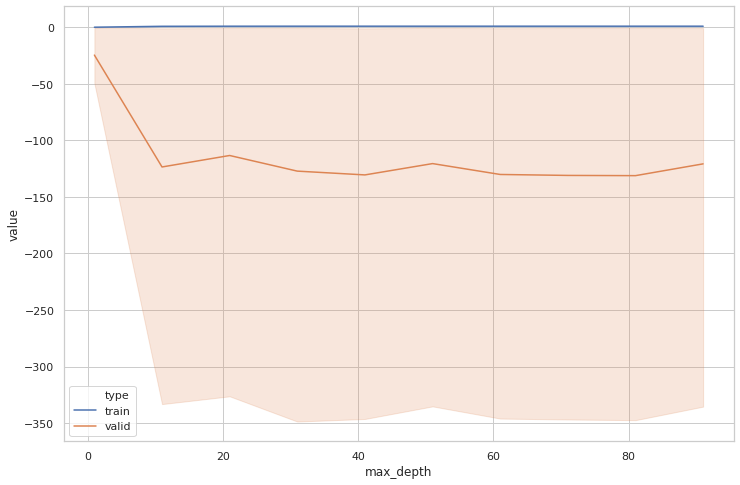

In [191]:
sum(df['timeScaledPageRank_1']>cutoff) / sum(df['timeScaledPageRank_predict']>cutoff)

0.5547594412829798

1.3215441902612113


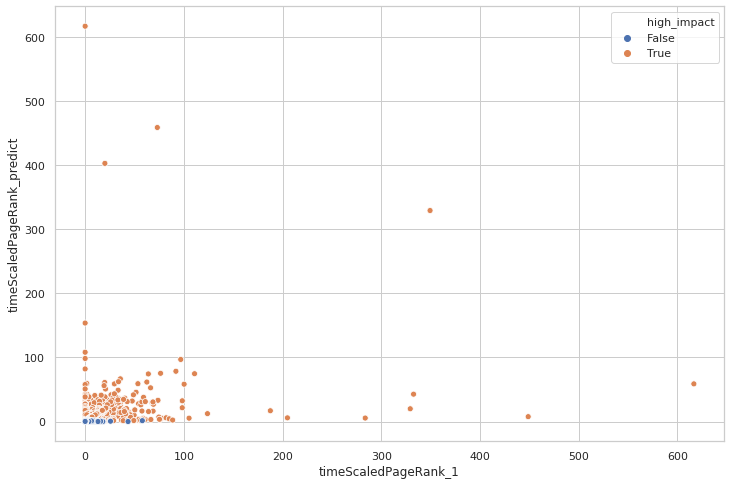

In [199]:
print(cutoff)
sns.scatterplot(data=df, x='timeScaledPageRank_1', y='timeScaledPageRank_predict', hue='high_impact')

In [86]:
y_pred = clf.predict(X_test)



from sklearn.metrics import f1_score, classification_report
print("F1 Score: {}".format(f1_score(y_true=y_test, y_pred=y_pred)))

print(classification_report(y_true=y_test, y_pred=y_pred))

F1 Score: 0.8567451930511882
             precision    recall  f1-score   support

      False       0.86      0.85      0.86      9660
       True       0.85      0.86      0.86      9670

avg / total       0.86      0.86      0.86     19330



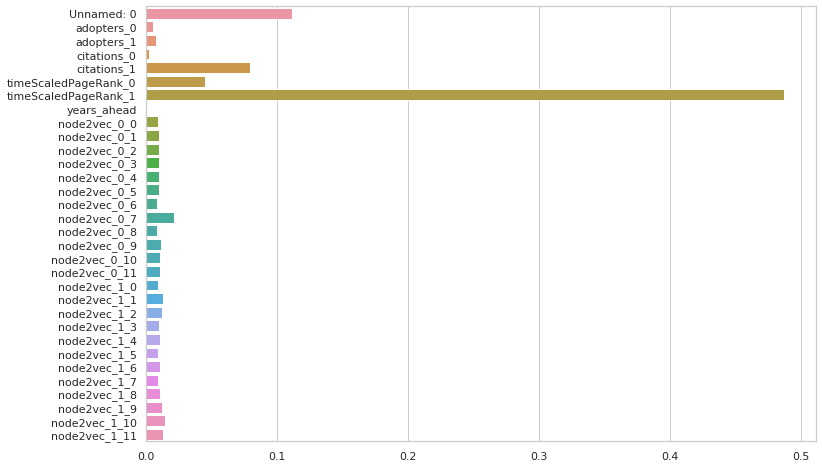

In [61]:
feature_importance = pd.DataFrame.from_dict(
    dict(zip(X.columns, clf.feature_importances_)), orient='index').T
sns.barplot(orient='h',data=feature_importance)

Text(84.5, 0.5, 'True')

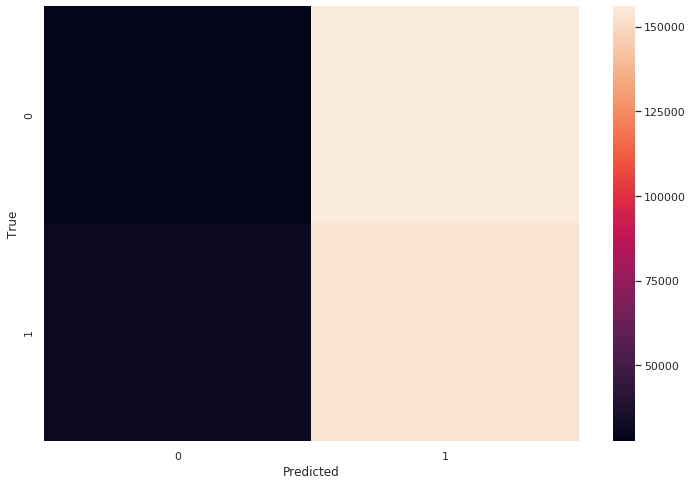

In [63]:
from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
ax = sns.heatmap(conf_mat)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

# df.drop(columns='lr_predicted')
df.loc[test_inds, 'lr_predicted'] = y_pred
df.loc[test_inds, 'lr_accuracy'] = (results['high_impact'] == results['dt_predicted']).astype(int)

print("Clasificationa accuracy: {}".format(clf.score(X_test, y_test)))
print("F1 Score: {}".format(f1_score(y_true=y_test, y_pred=y_pred)))

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
ax = sns.heatmap(conf_mat)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

feature_importance = pd.DataFrame.from_dict(
    dict(zip(X.columns, clf.feature_importances_)), orient='index').T
sns.barplot(orient='h',data=feature_importance)

In [35]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
if 'dt_predicted' in df.columns:
    df.drop(columns='dt_predicted')
df.loc[test_inds, 'dt_predicted'] = y_pred
df.loc[test_inds, 'dt_correct'] = (results['high_impact'] == results['dt_predicted']).astype(int)

print("Clasificationa accuracy: {}".format(clf.score(X_test, y_test)))
print("F1 Score: {}".format(f1_score(y_true=y_test, y_pred=y_pred)))

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
ax = sns.heatmap(conf_mat)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

feature_importance = pd.DataFrame.from_dict(
    dict(zip(X.columns, clf.feature_importances_)), orient='index').T
sns.barplot(orient='h',data=feature_importance)

ValueError: Must have equal len keys and value when setting with an iterable

ValueError: Must have equal len keys and value when setting with an iterable

In [546]:
sns.lineplot(x='year', y='decision_treeclassification_accuracy',
             data=df.loc[test_inds,:], 
             dashes=False, markers=True)

KeyError: 'dt_predicted'

In [243]:
!pip install tpot --user

     |████████████████████████████████| 81kB 35.9MB/s eta 0:00:01
     |████████████████████████████████| 20.4MB 47.8MB/s eta 0:00:01
     |████████████████████████████████| 153kB 56.5MB/s eta 0:00:01
     |████████████████████████████████| 286kB 54.1MB/s eta 0:00:01
Failed to build stopit
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Running setup.py install for stopit ... done
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, n_jobs=-1, 
                                                    scoring='r2', config_dict='TPOT light', 
                                                    max_time_mins=30, max_eval_time_mins=5) 
tpot.fit(X_train, y_train)



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeRegressor(MinMaxScaler(input_matrix), max_depth=9, min_samples_leaf=19, min_samples_split=6)


TPOTRegressor(config_dict='TPOT light', crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=1000000,
       max_eval_time_mins=5, max_time_mins=30, memory=None,
       mutation_rate=0.9, n_jobs=-1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=20,
       random_state=None, scoring='r2', subsample=1.0, template=None,
       use_dask=False, verbosity=2, warm_start=False)

In [13]:
tpot.score(X_test, y_test)

0.32070619981531434

In [14]:
tpot.export('tpot_exported_pipeline.py')

In [1]:
!cat tpot_exported_pipeline.py

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:0.24912375544428125
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    DecisionTreeRegressor(max_depth=9, min_samples_leaf=19, min_samples_split=6)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [6]:
years_ahead = 4
df = pd.read_csv('/tmp/data/quanta.predict.{miny}.{maxy}.{ya}.csv.out'.format(
        miny=min_year, maxy=max_year, ya=years_ahead))
df.shape

(773198, 36)

In [4]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running